# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-42384d9f-287d-4cbf-3f07-4a7245e93405)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-17 17:39:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2023-02-17 17:39:56 (20.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


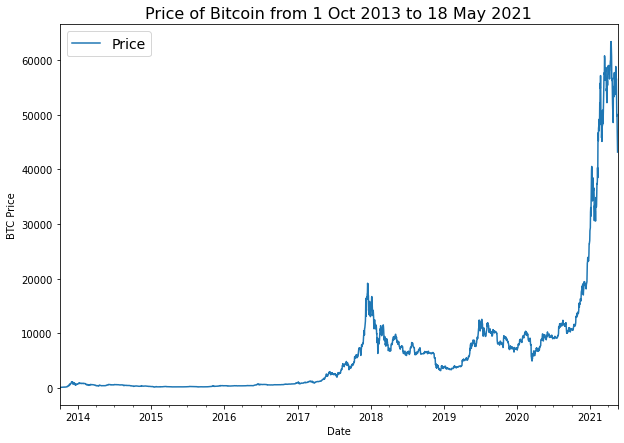

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

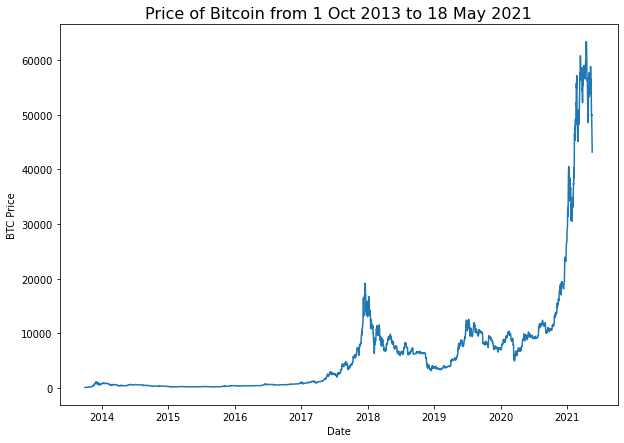

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

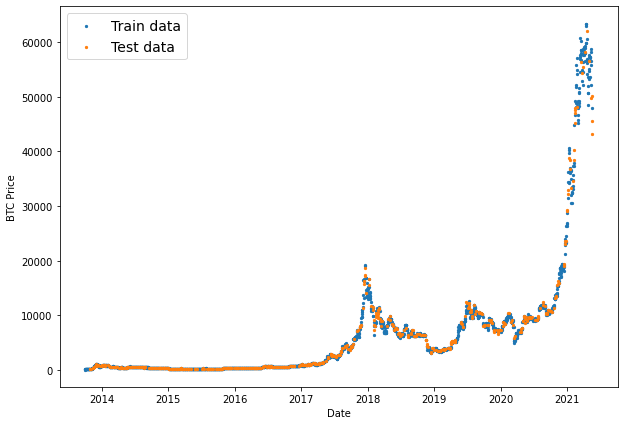

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

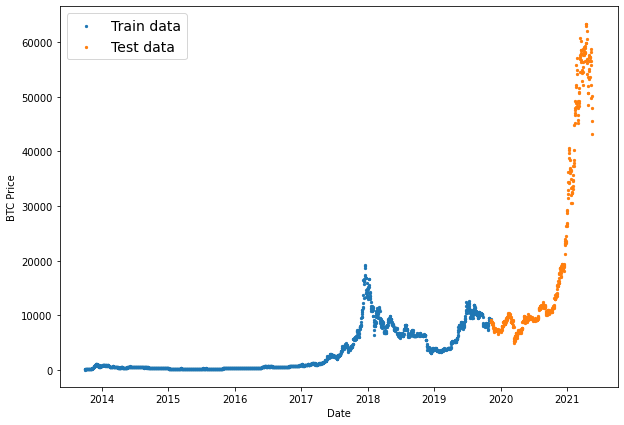

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

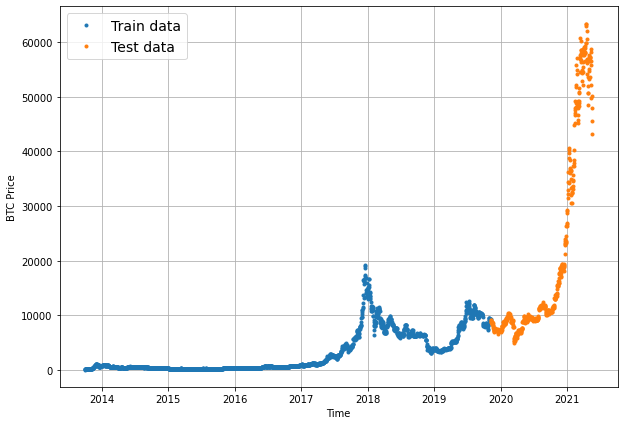

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

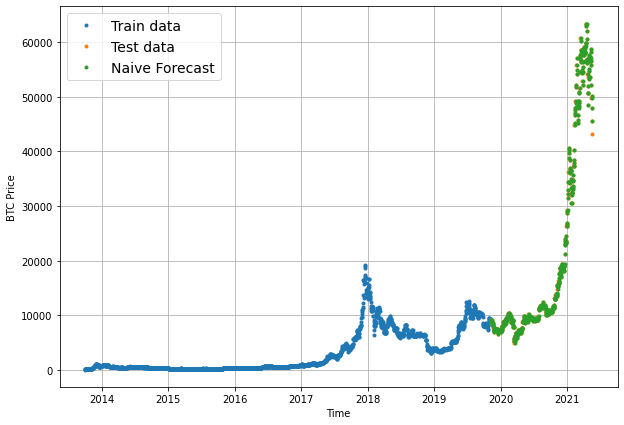

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

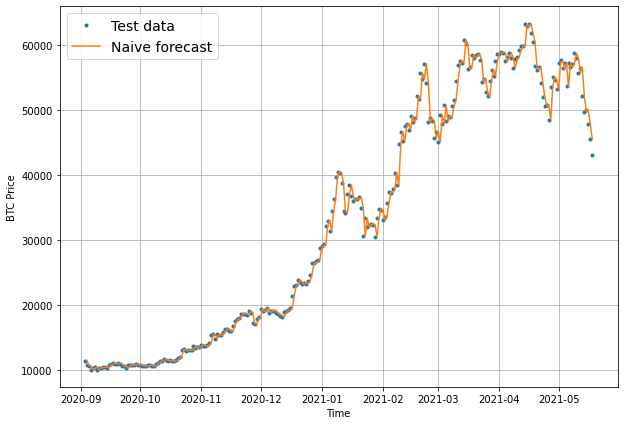

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 1:45 - loss: 1000.3937 - mae: 1000.3937

18/18 [==============================] - 7s 74ms/step - loss: 356.0833 - mae: 356.0833 - val_loss: 1682.2142 - val_mae: 1682.2142
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 216.7373 - mae: 216.7373

18/18 [==============================] - 1s 40ms/step - loss: 194.9924 - mae: 194.9924 - val_loss: 943.2106 - val_mae: 943.2106
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 165.5934 - mae: 165.5934 - val_loss: 983.7570 - val_mae: 983.7570
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 165.1729 - mae: 165.1729 - val_loss: 973.2968 - val_mae: 973.2968
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 161.6020 - mae: 161.6020

18/18 [==============================] - 2s 96ms/step - loss: 158.6634 - mae: 158.6634 - val_loss: 870.7419 - val_mae: 870.7420
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 154.0160 - mae: 154.0160 - val_loss: 907.6194 - val_mae: 907.6194
Epoch 7/100
 9/18 [==============>...............] - ETA: 0s - loss: 162.1352 - mae: 162.1352

18/18 [==============================] - 1s 55ms/step - loss: 148.1245 - mae: 148.1245 - val_loss: 852.3058 - val_mae: 852.3058
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 132.1920 - mae: 132.1920

18/18 [==============================] - 1s 35ms/step - loss: 143.0608 - mae: 143.0608 - val_loss: 770.0879 - val_mae: 770.0879
Epoch 9/100
 9/18 [==============>...............] - ETA: 0s - loss: 142.4829 - mae: 142.4829

18/18 [==============================] - 1s 52ms/step - loss: 141.6586 - mae: 141.6586 - val_loss: 756.6910 - val_mae: 756.6910
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 141.7242 - mae: 141.7242 - val_loss: 787.7088 - val_mae: 787.7088
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 140.8960 - mae: 140.8960

18/18 [==============================] - 1s 53ms/step - loss: 141.7720 - mae: 141.7720 - val_loss: 733.3040 - val_mae: 733.3040
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 135.1459 - mae: 135.1459 - val_loss: 831.6082 - val_mae: 831.6082
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 146.1356 - mae: 146.1356 - val_loss: 783.3598 - val_mae: 783.3598
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 138.3138 - mae: 138.3138

18/18 [==============================] - 1s 50ms/step - loss: 137.9481 - mae: 137.9481 - val_loss: 701.5245 - val_mae: 701.5245
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 132.3935 - mae: 132.3935

18/18 [==============================] - 1s 45ms/step - loss: 136.6510 - mae: 136.6510 - val_loss: 699.7080 - val_mae: 699.7080
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 128.3439 - mae: 128.3439

18/18 [==============================] - 1s 46ms/step - loss: 128.3218 - mae: 128.3218 - val_loss: 690.7531 - val_mae: 690.7531
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 109.5218 - mae: 109.5218

18/18 [==============================] - 1s 41ms/step - loss: 127.5987 - mae: 127.5987 - val_loss: 690.1496 - val_mae: 690.1496
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 129.0583 - mae: 129.0583

18/18 [==============================] - 2s 95ms/step - loss: 126.0175 - mae: 126.0175 - val_loss: 672.5667 - val_mae: 672.5667
Epoch 19/100
18/18 [==============================] - 0s 14ms/step - loss: 129.1051 - mae: 129.1051 - val_loss: 763.6337 - val_mae: 763.6337
Epoch 20/100
18/18 [==============================] - 0s 12ms/step - loss: 124.8071 - mae: 124.8071 - val_loss: 673.4790 - val_mae: 673.4790
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 129.0014 - mae: 129.0014

18/18 [==============================] - 1s 76ms/step - loss: 126.9613 - mae: 126.9613 - val_loss: 649.8799 - val_mae: 649.8799
Epoch 22/100
18/18 [==============================] - 0s 14ms/step - loss: 123.4308 - mae: 123.4308 - val_loss: 707.8129 - val_mae: 707.8129
Epoch 23/100
12/18 [===================>..........] - ETA: 0s - loss: 122.4381 - mae: 122.4381

18/18 [==============================] - 2s 114ms/step - loss: 125.0359 - mae: 125.0359 - val_loss: 639.6282 - val_mae: 639.6282
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 123.9205 - mae: 123.9205

18/18 [==============================] - 1s 61ms/step - loss: 121.0560 - mae: 121.0560 - val_loss: 633.3692 - val_mae: 633.3692
Epoch 25/100
18/18 [==============================] - 0s 10ms/step - loss: 117.6929 - mae: 117.6929 - val_loss: 644.3737 - val_mae: 644.3737
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 124.7914 - mae: 124.7914

18/18 [==============================] - 1s 52ms/step - loss: 122.2554 - mae: 122.2554 - val_loss: 623.3707 - val_mae: 623.3707
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 125.9320 - mae: 125.9320

18/18 [==============================] - 1s 56ms/step - loss: 122.5484 - mae: 122.5484 - val_loss: 618.8157 - val_mae: 618.8157
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 117.5261 - mae: 117.5261

18/18 [==============================] - 1s 62ms/step - loss: 116.2366 - mae: 116.2366 - val_loss: 615.4773 - val_mae: 615.4773
Epoch 29/100
18/18 [==============================] - 0s 12ms/step - loss: 114.5903 - mae: 114.5903 - val_loss: 624.0556 - val_mae: 624.0556
Epoch 30/100
18/18 [==============================] - 0s 12ms/step - loss: 122.4916 - mae: 122.4916 - val_loss: 618.9220 - val_mae: 618.9220
Epoch 31/100
10/18 [===============>..............] - ETA: 0s - loss: 112.9965 - mae: 112.9965

18/18 [==============================] - 1s 62ms/step - loss: 113.1570 - mae: 113.1570 - val_loss: 612.9691 - val_mae: 612.9691
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 117.8666 - mae: 117.8666

18/18 [==============================] - 1s 56ms/step - loss: 113.5941 - mae: 113.5941 - val_loss: 608.2818 - val_mae: 608.2818
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 116.0948 - mae: 116.0948 - val_loss: 679.0649 - val_mae: 679.0649
Epoch 34/100
11/18 [=================>............] - ETA: 0s - loss: 119.2103 - mae: 119.2103

18/18 [==============================] - 1s 60ms/step - loss: 114.4816 - mae: 114.4816 - val_loss: 595.9810 - val_mae: 595.9810
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5273 - mae: 111.5273 - val_loss: 628.8455 - val_mae: 628.8455
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 116.7080 - mae: 116.7080 - val_loss: 596.2070 - val_mae: 596.2070
Epoch 37/100
14/18 [======================>.......] - ETA: 0s - loss: 113.3715 - mae: 113.3715

18/18 [==============================] - 1s 59ms/step - loss: 111.8351 - mae: 111.8351 - val_loss: 593.1260 - val_mae: 593.1260
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 113.6868 - mae: 113.6868 - val_loss: 635.4493 - val_mae: 635.4493
Epoch 39/100
14/18 [======================>.......] - ETA: 0s - loss: 113.5209 - mae: 113.5209

18/18 [==============================] - 1s 74ms/step - loss: 110.8291 - mae: 110.8291 - val_loss: 585.0121 - val_mae: 585.0121
Epoch 40/100
13/18 [====================>.........] - ETA: 0s - loss: 110.9978 - mae: 110.9978

18/18 [==============================] - 2s 117ms/step - loss: 109.7410 - mae: 109.7410 - val_loss: 582.0229 - val_mae: 582.0229
Epoch 41/100
13/18 [====================>.........] - ETA: 0s - loss: 112.2138 - mae: 112.2138

18/18 [==============================] - 2s 92ms/step - loss: 109.4414 - mae: 109.4414 - val_loss: 580.2147 - val_mae: 580.2147
Epoch 42/100
18/18 [==============================] - 0s 11ms/step - loss: 112.2094 - mae: 112.2094 - val_loss: 620.8680 - val_mae: 620.8680
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 108.0130 - mae: 108.0130

18/18 [==============================] - 1s 54ms/step - loss: 111.7931 - mae: 111.7931 - val_loss: 579.5071 - val_mae: 579.5071
Epoch 44/100
18/18 [==============================] - 0s 9ms/step - loss: 108.5443 - mae: 108.5443 - val_loss: 583.7665 - val_mae: 583.7665
Epoch 45/100
18/18 [==============================] - 0s 13ms/step - loss: 110.4435 - mae: 110.4435 - val_loss: 607.4604 - val_mae: 607.4604
Epoch 46/100
18/18 [==============================] - 0s 13ms/step - loss: 109.6203 - mae: 109.6203 - val_loss: 754.4028 - val_mae: 754.4028
Epoch 47/100
12/18 [===================>..........] - ETA: 0s - loss: 117.6021 - mae: 117.6021

18/18 [==============================] - 2s 100ms/step - loss: 122.0181 - mae: 122.0181 - val_loss: 573.2593 - val_mae: 573.2593
Epoch 48/100
18/18 [==============================] - 0s 16ms/step - loss: 115.1413 - mae: 115.1413 - val_loss: 710.4995 - val_mae: 710.4995
Epoch 49/100
14/18 [======================>.......] - ETA: 0s - loss: 120.7137 - mae: 120.7137

18/18 [==============================] - 1s 65ms/step - loss: 118.3521 - mae: 118.3521 - val_loss: 571.9080 - val_mae: 571.9080
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 113.9305 - mae: 113.9305 - val_loss: 746.5556 - val_mae: 746.5557
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 117.0430 - mae: 117.0430 - val_loss: 615.4567 - val_mae: 615.4567
Epoch 52/100
18/18 [==============================] - 0s 9ms/step - loss: 116.5526 - mae: 116.5526 - val_loss: 626.8187 - val_mae: 626.8187
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 109.9871 - mae: 109.9871 - val_loss: 588.2382 - val_mae: 588.2382
Epoch 54/100
13/18 [====================>.........] - ETA: 0s - loss: 105.9897 - mae: 105.9897

18/18 [==============================] - 1s 68ms/step - loss: 107.9050 - mae: 107.9050 - val_loss: 567.7510 - val_mae: 567.7510
Epoch 55/100
18/18 [==============================] - 0s 8ms/step - loss: 110.7133 - mae: 110.7133 - val_loss: 592.2500 - val_mae: 592.2500
Epoch 56/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9300 - mae: 112.9300 - val_loss: 891.0270 - val_mae: 891.0270
Epoch 57/100
18/18 [==============================] - 0s 11ms/step - loss: 131.6731 - mae: 131.6731 - val_loss: 650.2655 - val_mae: 650.2655
Epoch 58/100
18/18 [==============================] - 0s 11ms/step - loss: 121.7032 - mae: 121.7032 - val_loss: 652.4509 - val_mae: 652.4509
Epoch 59/100
18/18 [==============================] - 0s 11ms/step - loss: 114.6572 - mae: 114.6572 - val_loss: 637.1786 - val_mae: 637.1786
Epoch 60/100
18/18 [==============================] - 0s 13ms/step - loss: 112.0625 - mae: 112.0625 - val_loss: 623.9566 - val_mae: 623.9566
Epoch 61/100
16/18 [========

18/18 [==============================] - 1s 72ms/step - loss: 108.4939 - mae: 108.4939 - val_loss: 565.1385 - val_mae: 565.1385
Epoch 62/100
18/18 [==============================] - 0s 14ms/step - loss: 107.1562 - mae: 107.1562 - val_loss: 572.4548 - val_mae: 572.4548
Epoch 63/100
18/18 [==============================] - 0s 19ms/step - loss: 111.4803 - mae: 111.4803 - val_loss: 604.1482 - val_mae: 604.1482
Epoch 64/100
18/18 [==============================] - 0s 10ms/step - loss: 109.9828 - mae: 109.9828 - val_loss: 592.8640 - val_mae: 592.8640
Epoch 65/100
18/18 [==============================] - 0s 13ms/step - loss: 109.2408 - mae: 109.2408 - val_loss: 575.3091 - val_mae: 575.3091
Epoch 66/100
18/18 [==============================] - 0s 17ms/step - loss: 107.6746 - mae: 107.6746 - val_loss: 595.0099 - val_mae: 595.0099
Epoch 67/100
18/18 [==============================] - 0s 15ms/step - loss: 108.5324 - mae: 108.5324 - val_loss: 692.6935 - val_mae: 692.6935
Epoch 68/100
18/18 [======

18/18 [==============================] - 1s 61ms/step - loss: 110.2031 - mae: 110.2031 - val_loss: 564.4868 - val_mae: 564.4868
Epoch 74/100
18/18 [==============================] - 0s 9ms/step - loss: 109.2204 - mae: 109.2204 - val_loss: 577.9415 - val_mae: 577.9415
Epoch 75/100
11/18 [=================>............] - ETA: 0s - loss: 107.3671 - mae: 107.3671

18/18 [==============================] - 1s 55ms/step - loss: 109.5217 - mae: 109.5217 - val_loss: 562.0039 - val_mae: 562.0039
Epoch 76/100
18/18 [==============================] - 0s 9ms/step - loss: 111.0327 - mae: 111.0327 - val_loss: 575.8726 - val_mae: 575.8726
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 109.2102 - mae: 109.2102 - val_loss: 584.7859 - val_mae: 584.7859
Epoch 78/100
18/18 [==============================] - 0s 10ms/step - loss: 108.7549 - mae: 108.7549 - val_loss: 599.3093 - val_mae: 599.3093
Epoch 79/100
18/18 [==============================] - 0s 12ms/step - loss: 107.4748 - mae: 107.4748 - val_loss: 592.0253 - val_mae: 592.0253
Epoch 80/100
18/18 [==============================] - 0s 8ms/step - loss: 109.6550 - mae: 109.6550 - val_loss: 590.0011 - val_mae: 590.0011
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 106.2724 - mae: 106.2724 - val_loss: 563.6845 - val_mae: 563.6845
Epoch 82/100
18/18 [=========

18/18 [==============================] - 1s 77ms/step - loss: 110.0289 - mae: 110.0289 - val_loss: 561.1447 - val_mae: 561.1447
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 107.7870 - mae: 107.7870 - val_loss: 563.1964 - val_mae: 563.1964
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 104.5233 - mae: 104.5233 - val_loss: 573.3968 - val_mae: 573.3968
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 109.2763 - mae: 109.2763 - val_loss: 570.0250 - val_mae: 570.0250
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 108.6874 - mae: 108.6874 - val_loss: 612.1595 - val_mae: 612.1595
Epoch 93/100
18/18 [==============================] - 0s 9ms/step - loss: 111.8540 - mae: 111.8540 - val_loss: 576.2726 - val_mae: 576.2726
Epoch 94/100
18/18 [==============================] - 0s 9ms/step - loss: 110.0960 - mae: 110.0960 - val_loss: 561.2537 - val_mae: 561.2537
Epoch 95/100
18/18 [===========

In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.9592 - mae: 569.9592


[569.959228515625, 569.959228515625]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 561.1446 - mae: 561.1446


[561.1445922851562, 561.1445922851562]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8831.793, 8766.315, 9032.331, 8777.367, 8731.973, 8719.11 ,
        8681.09 , 8517.032, 8442.11 , 8519.224], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 561.1446,
 'mse': 1144953.4,
 'rmse': 1070.0249,
 'mape': 2.5132928,
 'mase': 0.98577565}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

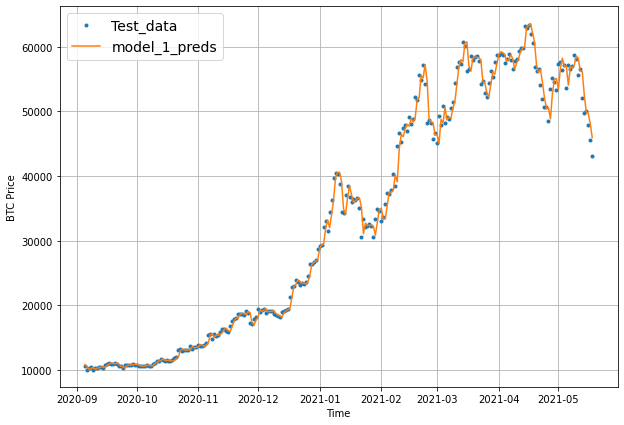

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 599.0822


599.0821533203125

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 599.0822


599.0821533203125

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57690.99 , 57129.54 , 58271.582, 56751.82 , 56505.887, 54047.082,
       49308.754, 50882.395, 48140.7  , 46585.38 ], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 599.08215,
 'mse': 1274633.2,
 'rmse': 1128.9966,
 'mape': 2.692077,
 'mase': 1.0472015}

### Model 3: Dense (window = 30, horizon = 7)

In [51]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [52]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [53]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [54]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 679.1817


679.1817016601562

In [55]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 613.8173


613.8173217773438

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([53774.953, 49833.87 , 50261.89 , 49434.79 , 46077.207],
      dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 613.8173,
 'mse': 1265461.8,
 'rmse': 1124.9274,
 'mape': 2.7913134,
 'mase': 1.0729587}

### Make our evaluation function work for larger horizon